**Closed-loop EMPC WITHOUT terminal constraints N=100**

***Instructions:*** 
- To reproduce results for closed-loop EMPC WITHOUT terminal constraints with varying N, change the value of N (in cell 4) to the N of the result being reproduced. 
- If the user wants to plot the state trajectory, input trajectory and costs incurred for a shorter length of operation time, specify this change in t_max in cell 11 (ex., if you want to plot the results only until 1.25 s, change the value of t_max to 1.25 s). 
- To calculate the total economic cost for a length of operation shorter than 5.0 s, the user can extract and sum up the cost history in line 10 for the start and end time step of interest. For example, if the user is interested in summing up the cost for a length of operation of 2.5 s, change print(np.sum(cost_history)) to print(np.sum(cost_history[0:6::])). This adds up the cost from time step 0 to time step 5 (zero-based indexing), which is equivalent to 0.0 to 0.25 s, given that the sample period dt is 0.05.

In [1]:
from casadi import *
import matplotlib.pyplot as plt

In [2]:
def model(x ,u, xs = None, us = None):
    """Compute the right-hand side of the ODEs
    
    Args: 
        x (array-like): State vector
        u (array-like): Input vector
        xs (array-like, optional): steady-state
        us (array-like, optional): steady-state input
    Returns:
        array-like: dx/dt
    """
    if xs is not None:
        # Assume x is in deviation variable form
        x = [x[i] + xs[i] for i in range(1)]
    if us is not None:
        # Assume u is in deviation variable form
        u = [u[i] + us[i] for i in range(1)]
        
    dxdt = [x[0] + u[0]]
    return dxdt

In [3]:
# Get the steady state
us = -3
xs = 3

In [4]:
# Parameters (used in optimal control problem later as well)
T = 5.0
N = 100
dt = T/N

In [5]:
t = SX.sym("t", 1, 1)
x = SX.sym("x", 1, 1)
u = SX.sym("u", 1, 1)
ode = vertcat(*model (x, u))
print(ode, ode.shape)
print(type(ode))

(x+u) (1, 1)
<class 'casadi.casadi.SX'>


In [6]:
# Construct an integrating block x_k+1
f = {'x' : x, 't' : t, 'p' : u, 'ode' : ode}
Phi = integrator("Phi", "cvodes", f, {'tf' : dt})

In [7]:
# System Model - in general, the system model
# and the MPC model are different
system = Phi

In [8]:
# Define the decision variable and constraints
s = vertcat(*[MX.sym(f'x{i}', 1, 1) for i in range (N+1)])
q = vertcat(*[MX.sym(f'u{i}', 1, 1) for i in range(N)])
z = []
zlb = []
zub = []
constraints = []

# Create a function
cost = 0.
ulb = [-10]
uub = [10]

for i in range(N):
    s_i = s[i: i+1]
    s_ipl = s[i+1:i+2]
    q_i = q[i:i+1]
    
    # Decision variable
    zlb += [-np.inf]
    zlb[0] = 1
    zub += [np.inf]
    zub[0] = 1
    zlb += ulb
    zub += uub
        
    z.append(s_i)
    z.append(q_i)    
    
    xt_ipl = Phi(x0=s_i, p=q_i)['xf']
    cost += 2*(q_i + 10) + (s_i - 2)**2
    constraints.append(xt_ipl - s_ipl)
    
# s_N
z.append(s_ipl)
zlb += [-np.inf]
zub += [np.inf]

constraints = vertcat(*constraints)
variables = vertcat(*z)

In [9]:
# Create the optimization problem 
g_lb = np.zeros(N)
g_ub = np.zeros(N)
nlp = {'f' : cost, 'g': constraints, 'x': variables}
opt = {'print_time': 0, 'ipopt.print_level':0}
solver = nlpsol('solver', 'ipopt', nlp, opt)
def solve_empc(x): 
    """Solve EMPC provided x
    
    Args:
        x  (array-like): current state
    Returns:
        typle: current input and return status pair
    """
    for i in range(1):
        zlb[i] = x[i]
        zub[i] = x[i]

    sol_out = solver(lbx=zlb, ubx=zub, lbg=g_lb, ubg=g_ub)
    return (np.array(sol_out['x'][1:2]), solver.stats()['return_status'])

In [10]:
state_history = np.zeros((N+1, 1))
input_history = np.zeros((N+1, 1))
state_history[0, :] = 1
xk = state_history[0,:]
cost_history = np.zeros((N+1, 1))
cost = cost_history

time = [i*dt for i in range(N+1)]

# Closed-loop simulation
for k in range(N+1):
    
    print(f'Current time: {k*dt}')
    uk, status = solve_empc(xk)
    print(f'Solver status: {status}')
    cost_history[k, :] = 2*(uk + 10) + (xk - 2)**2

    xk_p1 = np.array(system(x0=xk, p=uk)['xf'])    
    
    xk_p1 = xk_p1.reshape((1,))
    uk = uk.reshape((1,))
    
    input_history[k, :] = uk
    state_history[k+1:k+2, :] = xk_p1
    xk = xk_p1

input_history[N, :] = uk
print(np.sum(cost_history))

Current time: 0.0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Solver status: Solve_Succeeded
Current time: 0.05
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.15000000000000002
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.25
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.35000000000000003
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.45
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.55
Solv

<Figure size 1008x1008 with 0 Axes>

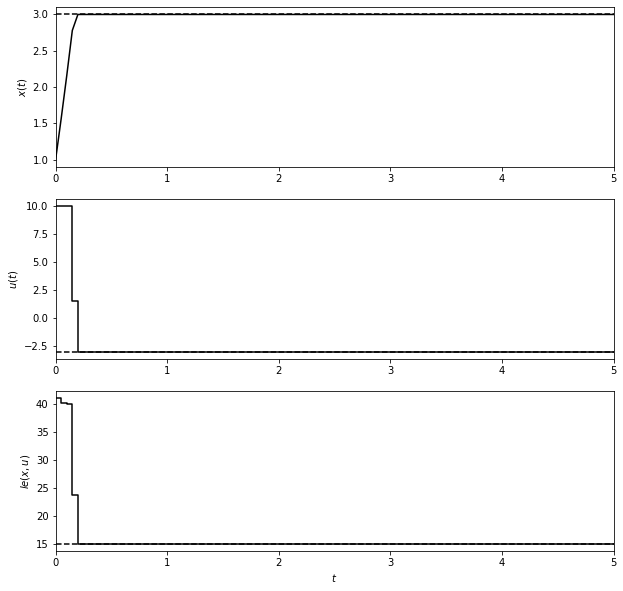

In [11]:
# Figure
cost_ss = 15
plt.figure(figsize=[14,14])
fig, axs = plt.subplots(3, 1, figsize=[10,10])
t_max = min(10, N*dt)
for j in range(1):
    axs[j].plot(time, state_history[:, j], 'k-',
                [time[0], time[-1]], [xs, xs], 'k--')
    axs[j].set_ylabel(f'$x(t)$')
    axs[j].set_xlim([0, t_max])
    
for j in range(1):
    axs[j+1].step(time, input_history[:, j], 'k-',
                  [time[0], time[-1]], [us, us], 'k--',
                  where='post')
    axs[j+1].set_ylabel(f'$u(t)$')
    axs[j+1].set_xlim([0, t_max])
    
for j in range(1):
    axs[j+2].step(time, cost_history[:, j], 'k-',
                  [time[0], time[-1]], [cost_ss, cost_ss], 'k--',
                  where='post')
    axs[j+2].set_ylabel(f'$le(x,u)$')
    axs[j+2].set_xlim([0, t_max])
    axs[j+2].set_xlabel(f'$t$')
    
plt.savefig('CLWT100.png')

**Closed-loop EMPC WITHOUT terminal constraints N=100**
